In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Iterable, Tuple, List, Callable

In [2]:
IMAGE_SHAPE: Tuple[int, int] = (360, 480)	

In [3]:
def process(frame: np.ndarray) -> np.ndarray:
    frame = ((frame>40)*255).astype(np.uint8)
    frame = cv2.medianBlur(frame, 5)
    frame = cv2.morphologyEx(frame, cv2.MORPH_OPEN, np.ones((11, 11), np.uint8))
    frame = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, np.ones((27, 3), np.uint8))
    return frame

In [4]:
def generate_frames(frame: np.ndarray, processed: np.ndarray) -> None:
    _, _, stats, _ = cv2.connectedComponentsWithStats(processed)
    idx: int = 0
    if stats.shape[0] > 1:
        for pi in filter(lambda x: stats[x, 2] < stats[x, 3], range(1, stats.shape[0])):
            cv2.imwrite(f'patterns/sample_{idx}.png',  frame[stats[pi,0]:stats[pi,0]+stats[pi,2], stats[pi,1]:stats[pi,3]])
            idx += 1


In [5]:
def generate_model(patterns_path: str = "patterns") -> np.ndarray:
    propabilistic_model: np.ndarray = np.zeros((192, 64), np.float64)
    pattern_count: int = 0
    for pattern_path in os.listdir(patterns_path):
        pattern: np.ndarray = cv2.imread(os.path.join(patterns_path, pattern_path), cv2.IMREAD_GRAYSCALE)
        pattern = cv2.resize(pattern, (64, 192))/255.
        propabilistic_model += pattern
        pattern_count += 1
    return (propabilistic_model/pattern_count).astype(np.float64)

In [6]:
def get_iou(box1: Tuple[int], box2: Tuple[int]) -> float:
        _, left, top, right, bottom = box1
        _, left2, top2, right2, bottom2 = box2
        if min(right, right2) < max(left, left2) or min(bottom, bottom2) > max(top, top2):
            return 0.0
        intersection = (min(right, right2) - max(left, left2)) * (min(bottom, bottom2) - max(top, top2))
        union = (right - left) * (bottom - top) + (right2 - left2) * (bottom2 - top2) - intersection
        return intersection / union


In [7]:
def non_max_supression(
        maximal_images: np.ndarray, 
        box_shape: Tuple[int] = (192, 64),
        iou_threshold: float = 0.05
        ) -> np.ndarray:

    boxes: List[Tuple[int]] = []
    for x in range(maximal_images.shape[0]):
        for y in range(maximal_images.shape[1]):
            if maximal_images[x, y] > 1e-3:
                boxes.append((maximal_images[x, y], x-box_shape[0]//2, y-box_shape[1]//2, x+box_shape[0]//2, y+box_shape[1]//2))
    boxes.sort(key=lambda x: -x[0])
    active: np.ndarray = np.array([True]*len(boxes), dtype=bool)

    maxima = []
    for idx, box in enumerate(boxes):
        if active[idx]:
            maxima.append(box)
            if len(maxima) > 10: return maxima
            for idx2, box2 in enumerate(boxes[idx+1:], start=idx+1):
                if active[idx2] and get_iou(box, box2) > iou_threshold:
                    active[idx2] = False
                    
    
    return maxima


In [8]:
def analyze(
        frame: np.ndarray, 
        object_model: np.ndarray, 
        background_model: np.ndarray,
        threshold: float = 150000
        ) -> None:
    binary_frame = (frame > 40).astype(np.float64)
    binary_frame = cv2.medianBlur(frame, 5)
    binary_frame = cv2.morphologyEx(frame, cv2.MORPH_OPEN, np.ones((11, 11), np.float64))
    binary_frame = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, np.ones((27, 3), np.float64)).astype(np.float64)
    result = cv2.filter2D(binary_frame, -1, object_model) #-cv2.filter2D((1-binary_frame), -1, background_model)
    local_maxima = np.where(result > threshold, result, 0)
    boxes = non_max_supression(local_maxima)	
    for box in boxes:
        cv2.rectangle(frame, (box[2], box[1]), (box[4], box[3]), 255, 1)
    return frame

In [9]:
object_model = generate_model()
background_model = 1-object_model


In [11]:
cap = cv2.VideoCapture('data/vid1_IR.avi')
while(cap.isOpened()):
    ret, frame = cap.read()
    G = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    x = analyze(G, object_model, background_model)
    cv2.imshow("XXX", x)
    if cv2.waitKey(1) & 0xFF == ord("q"): 
        break
cv2.destroyAllWindows()
cap.release()

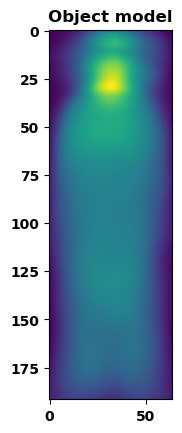

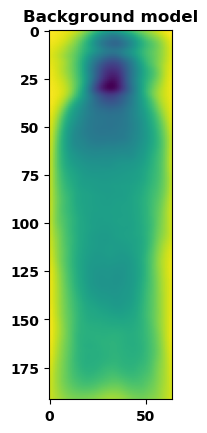

In [ ]:
plt.imshow(object_model)
plt.title("Object model")
plt.show()

plt.imshow(background_model)
plt.title("Background model")
plt.show()